# Predicting Walmart Sales
Avik Das

### Preliminaries:

The code block below imports all the libraries and functions used in this project.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from matplotlib import ticker
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

Contribution Checkpoints
    Section A: Project Idea (5%)
    Section B: Dataset Curation and Preprocessing (5%)
    Section C: Data Exploration and Summary Statistics (15%)
    Section D: ML Algorithm Design/Development (25%)
    Section E: ML Algorithm Training (20%)
    Section F: Visualization, Results Analysis, Conclusion (15%)
    Section G: Final Report Tutorial Creation (10%)

Avik Das, 100% (I did the whole project on my own)

We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial.

Avik Das - May 6th, 2023

I did everything by myself.

### Section A: Project Idea

My dataset is [this  Kaggle Dataset](https://www.kaggle.com/datasets/mikhail1681/walmart-sales) on Walmart Sales. I chose this dataset because I think that there could be some interesting trends in the data based on the factors in the dataset (time, unemployment). First, we import some starter libraries, and set up our dataset.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("Walmart_sales.csv")
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


### Section B: Dataset Curation and Preprocessing

Next we clean our data. First, I checked for duplicates, but there were none. I also checked for missing data, but everything seems to be filled and prepared for analysis.

Checking the datatypes, we see that Date is stored as an object rather than a datetime. We convert this using pandas. Everything else is already in an appropriate datatype. This allows us to begin analysis.

In [2]:
duplicates = df[df.duplicated() == True]
duplicates # since this is empty we have no duplicates

na_df = df.isna()
na_true_vals = na_df[(na_df['Store'] == True) | (na_df['Date'] == True) | (na_df['Weekly_Sales'] == True) | (na_df['Holiday_Flag'] == True) |
                     (na_df['Temperature'] == True) | (na_df['Fuel_Price'] == True) | (na_df['CPI'] == True) | (na_df['Unemployment'] == True)]
na_true_vals # since this is empty we have no missing data

df.dtypes
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df.dtypes
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


### Section C: Data Exploration and Summary Statistics

It is commonly thought that holidays generate a lot of sales. Let's use the holiday flag and see if there's any correlation between whether there's a holiday and the weekly sales of the store.

To do this, we'll apply the Mann Whitney U test, since the sales are not normally distributed, as shown in the plots following this analysis.

We then consider the following hypotheses:


> h_0: There is no difference in sales during holidays as compared to during no holidays

> h_a: There is a difference in sales during holidays as compared to during no holidays


We first split our dataset into two categories, one during the holidays and one without the holidays. These two sets will the be the basis for our Mann Whitney U, which will give us a value for p, which is the likelihood that the data comes from h_0. To conduct the Mann Whitny U, we use scipy's mannwhitneyu function. We find that the pvalue is 0.0258, suggesting that there is a 2.58% chance that the null hypothesis holds. Thus, it is likely that holidays are strongly correlated with sales, as common thought suggests.

In [3]:
from scipy.stats import mannwhitneyu

df_holidays = df[df['Holiday_Flag'] == 1]
df_no_holidays = df[df['Holiday_Flag'] == 0]

mannwhitneyu(df_holidays['Weekly_Sales'], df_no_holidays['Weekly_Sales'])

MannwhitneyuResult(statistic=1431297.0, pvalue=0.02589203255601349)

To show the difference in these two variables, we generate histograms of the sales for during holidays and during no holidays. This shows us both the distributions of the sales, as well as showing us the difference in sales during holidays.

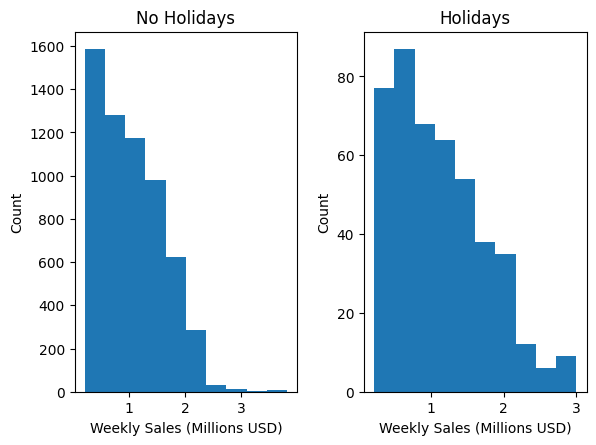

In [4]:
from matplotlib import ticker

df['Divided_Weekly_Sales'] = df['Weekly_Sales']/1_000_000

axes = df.hist('Divided_Weekly_Sales', by = 'Holiday_Flag', xrot = 0)

count = 0
for ax in axes.flatten():
  ax.set_ylabel("Count")
  ax.set_xlabel("Weekly Sales (Millions USD)")
  if (count == 0):
    ax.set_title("No Holidays")
  else:
    ax.set_title("Holidays")
  count += 1

Next, let's check if the consumer price index (CPI) is correlated with higher sales. The CPI aims to show changes in prices for goods often bought by consumers by creating a price for several goods commonly bought by consumers. Intuition suggests that higher consumer price index should lead to lower weekly sales. Let's try and test the validity of this hypothesis.

To do this, we'll check for correlation by using Pearson's correlation coefficient with the p-value. This is done using scipy's pearsonr function.

The p-value is 5.44 * 10^-9, which suggests that the CPI is correlated with weekly sales. However pearson's r is low, which suggests that the linear trend is weak.


In [5]:
from scipy.stats import pearsonr

pearsonr(df['Weekly_Sales'], df['CPI'])

PearsonRResult(statistic=-0.07263416204017623, pvalue=5.438292612176735e-09)

To better see the trend between the two, let's use a scatterplot to show the trend. We'll put CPI in the x-axis and Weekly Sales in the y-axis.

Looking at the scatterplot, it is clear that there is certainly no linear relationship. However, it is clear that there are large buckets in the CPI, namely, 125-145, 180-200, and 200-230. It's unclear why these specific buckets have emerged, but it is likely there is a reason that needs exploring to find out why they have emerged.

Text(0, 0.5, 'Weekly Sales (Millions USD)')

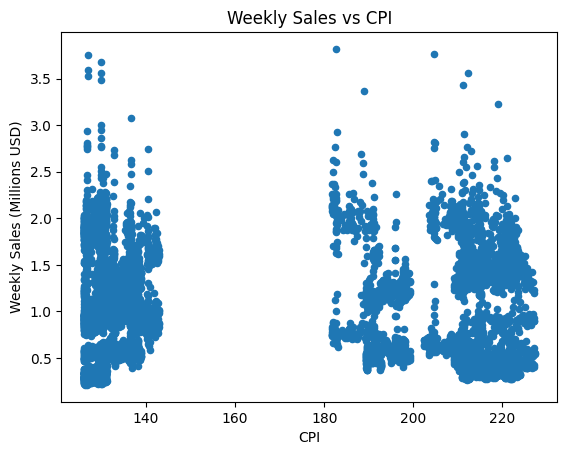

In [6]:
axes = df.plot.scatter(x = 'CPI', y = 'Divided_Weekly_Sales')

axes.set_title("Weekly Sales vs CPI")
axes.set_ylabel("Weekly Sales (Millions USD)")

Let's get a breakdown of which stores sell the most and which stores sell the least. To do this, we'll first calculate the total sales for each store. Then, we'll create a pie chart to visualize the amount of sales for each store relative to the total sales.

Looking at the pie chart, we see that no particular store constitutes more than 1/15 of the total profits of all the walmarts. When we take a look at a bar chart plotting the sales, we see that stores range \$40 million and \$300 million total profits (for our dataset).

<Axes: ylabel='Weekly_Sales'>

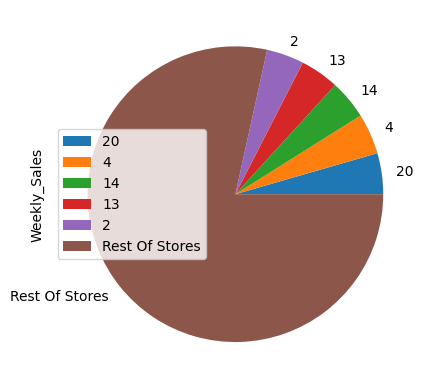

In [7]:
store_sales_series = df.groupby("Store")['Weekly_Sales'].sum()
store_sales_series = store_sales_series.sort_values(ascending = False)
not_top_ten_sum = store_sales_series.tail(len(store_sales_series) - 5).sum()
store_sales_df = store_sales_series.head(5).to_frame()
store_sales_df.loc['Rest Of Stores'] = not_top_ten_sum
store_sales_df['Divided_Weekly_Sales'] = store_sales_df['Weekly_Sales']/(1_000_000)
store_sales_df.plot.pie(y='Weekly_Sales')


Text(0, 0.5, 'Total Sales (Millions USD)')

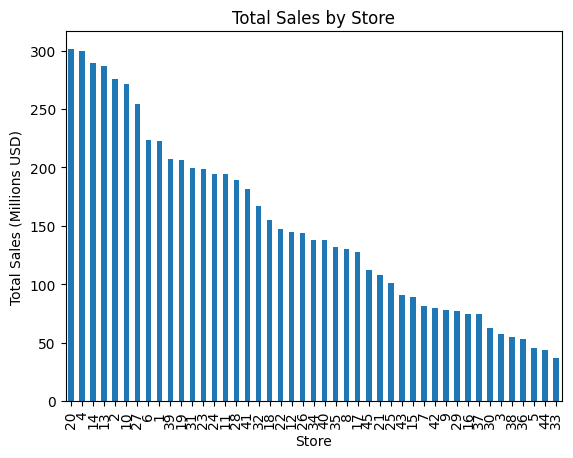

In [8]:
axes = (store_sales_series/1_000_000).plot.bar()
axes.set_title("Total Sales by Store")
axes.set_ylabel("Total Sales (Millions USD)")

Let's test for similarity in sales between different seasons. To do this, we'll first have to split our data into four seasons. I'm going to consider any date from December - February as winter, any date from March - May as spring, any date from June - August as summer, and any date from September - November as fall (I know these don't technically line up with the official dates for winter, but December 20th feels a lot more like winter than it does like fall).

We'll then use ANOVA to analyse if these four seasons each have similar distributions of sales. Consider the following hypotheses:

> h_0: All 4 seasons have the same distribution of weekly sales.

> h_a: There is one of the seasons that has a different distribution in weekly sales.

ANOVA will give us a p-value which will allow us to check for the likelihood of each of these hypotheses. To perform ANOVA, we'll use scipy's f_oneway function. Performing ANOVA, we see that we have a p-value of 0.13, which is more than 0.05. Thus, there is a 13% chance that the null hypothesis is true, so we would consider this not statistically significant. If the it were to be statistically significant, we would want to consider some post-hoc tests, but that seems unnecessary for the time being.

To visualize the differences (even though not statistically significant), we'll create a histogram for the weekly sales during each season. Looking at the histogram, we can see that there are slight differences, but they all approximate a similar shape.

In [9]:
from scipy.stats import f_oneway

df_winter = df[(df['Date'].dt.month == 1) | (df['Date'].dt.month == 2) | (df['Date'].dt.month == 12)]
df_spring = df[(df['Date'].dt.month == 3) | (df['Date'].dt.month == 4) | (df['Date'].dt.month == 5)]
df_summer = df[(df['Date'].dt.month == 6) | (df['Date'].dt.month == 7) | (df['Date'].dt.month == 8)]
df_fall = df[(df['Date'].dt.month == 9) | (df['Date'].dt.month == 10) | (df['Date'].dt.month == 11)]

f_oneway(df_winter['Weekly_Sales'], df_spring['Weekly_Sales'], df_summer['Weekly_Sales'], df_fall['Weekly_Sales'])

F_onewayResult(statistic=4.683342443521907, pvalue=0.0028568353078323927)

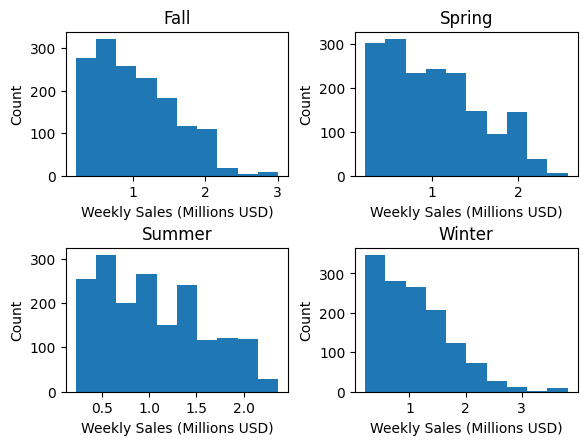

In [10]:
def season_mapping(x):
  if 3 <= x <= 5:
    return "Spring"
  elif 6 <= x <= 8:
    return "Summer"
  elif 9 <= x <= 11:
    return "Fall"
  else:
    return "Winter"

df['Season'] = df['Date'].dt.month
df['Season'] = df['Season'].apply(season_mapping)

axes = df.hist('Divided_Weekly_Sales', by = 'Season', xrot = 0)

for ax in axes.flatten():
  ax.set_ylabel("Count")
  ax.set_xlabel("Weekly Sales (Millions USD)")

After doing some exploratory data analysis, we've found a couple of interesting trends and correlations between factors. This will be useful as we transition into the later phases of analysis, where we'll eventually try to build up a model which can estimate the weekly sales based off of the factors present in the dataset. We haven't really investigated temperature and fuel price yet, but as we move forward, we'll have to investigate their relationship to weekly sales as well. Moving forward, it would also be interesting to analyse on a store by store basis, and see if any specific factors are more statistically relevant in certain stores as compared to others.

### Section D: ML Algorithm Design/Development

Let's build some predictors to try and predict Walmart weekly sales based on certain factors. We'll try the following three models to predict weekly sales:


1.   K Nearest Neighbors (n_neighbors = 5)
2.   Linear Regression
3.   Polynomial Regression
4.   Neural Network (using the Adam optimizer)

We'll then analyze the success of these various methods, and see which one performed the best.

To implement these methods, we will use the sklearn library for the first 3, and the PyTorch library for our neural network.

Before implementing our machine learning, we once again have to clean up our data, and decide on some hyperparameters we'll be using. Let's tackle cleaning up the data first.The data preparation methods have been described in the list below.  

*   Since our weekly sales data is the target, we won't need to normalize it. However, for the sake of making our errors readable (squaring numbers in the orders of millions gets big very quickly), we'll use the already defined divided_weekly_sales column as our target.
*   For our season and holiday columns, we'll apply one-hot encoding as they are categorical variables.
*   For our numerical features, we'll use Z-score normalization, as these come closer to approximating a normal distribution (temperature is approximately normal, fuel_price follows a bimodal distribution, CPI doesn't really follow anything, and Unemployment is approximately normal)



We'll also need to decide on a test training split. We'll use an 80/20 split in order to have a good amount of training data while not overfitting. Now that we have a plan of what to do, we'll import the necessary functions and use them to put our plan into action.

### Section E: ML Algorithm Training

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

model_df = df
model_df = pd.get_dummies(df, columns = ['Season', 'Holiday_Flag'])

X = model_df.drop(['Date', 'Store', 'Weekly_Sales'], axis=1)
y = model_df['Divided_Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

knn = KNeighborsRegressor()
y_knn_train_pred = knn.fit(X_train_scaled, y_train).predict(X_train_scaled)
y_knn_test_pred = knn.fit(X_train_scaled, y_train).predict(X_test_scaled)

mse_knn_train = mean_squared_error(y_train, y_knn_train_pred)
mse_knn_test = mean_squared_error(y_test, y_knn_test_pred)
r2_knn_train = r2_score(y_train, y_knn_train_pred)
r2_knn_test = r2_score(y_test, y_knn_test_pred)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree_linear = 1
degree_poly = 3

pipe_linear = make_pipeline(PolynomialFeatures(degree=degree_linear), LinearRegression())
pipe_poly = make_pipeline(PolynomialFeatures(degree=degree_poly), LinearRegression())

y_linear_train_pred = pipe_linear.fit(X_train_scaled, y_train).predict(X_train_scaled)
y_poly_train_pred = pipe_poly.fit(X_train_scaled, y_train).predict(X_train_scaled)
y_linear_test_pred = pipe_linear.fit(X_train_scaled, y_train).predict(X_test_scaled)
y_poly_test_pred = pipe_poly.fit(X_train_scaled, y_train).predict(X_test_scaled)

mse_linear_train = mean_squared_error(y_train, y_linear_train_pred)
mse_linear_test = mean_squared_error(y_test, y_linear_test_pred)
r2_linear_train = r2_score(y_train, y_linear_train_pred)
r2_linear_test = r2_score(y_test, y_linear_test_pred)

mse_poly_train = mean_squared_error(y_train, y_poly_train_pred)
mse_poly_test = mean_squared_error(y_test, y_poly_test_pred)
r2_poly_train = r2_score(y_train, y_poly_train_pred)
r2_poly_test = r2_score(y_test, y_poly_test_pred)

In [29]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(input_size, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, output_size)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

neural_network = NeuralNetwork(X_train.shape[1], 1)

loss_function = nn.MSELoss()
optimizer = optim.Adam(neural_network.parameters(), lr=0.01)

num_epochs = 200
losses = []


for epoch in range(num_epochs):
  inputs = torch.tensor(X_train.to_numpy().astype(np.float32), dtype=torch.float32)
  targets = torch.tensor(y_train, dtype=torch.float32)

  pred = neural_network(inputs)
  loss = loss_function(pred, targets.view(-1, 1))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())


### Section F: Visualization, Result Analysis, Conclusion

Now that we've built our predictors, let's take a look at how they did. First, let's take a look at the mean squared error for all of our models. For our neural network, the value printed will the mean squared error of the final model, and for the others, we'll have different values for test and training data.

In [46]:
results = {
    "K Nearest Neighbors": {
        "MSE Train": mse_knn_train,
        "MSE Test": mse_knn_test,
        "R2 Train": r2_knn_train,
        "R2 Test": r2_knn_test
    },
    "Linear": {
        "MSE Train": mse_linear_train,
        "MSE Test": mse_linear_test,
        "R2 Train": r2_linear_train,
        "R2 Test": r2_linear_test
    },
    "Polynomial (Degree 3)": {
        "MSE Train": mse_poly_train,
        "MSE Test": mse_poly_test,
        "R2 Train": r2_poly_train,
        "R2 Test": r2_poly_test
    }
}

for method, metrics in results.items():
    print(f"{method} Method:")
    print(f"  MSE Train: {metrics['MSE Train']:.4f}")
    print(f"  MSE Test: {metrics['MSE Test']:.4f}")
    print(f"  R2 Train: {metrics['R2 Train']:.4f}")
    print(f"  R2 Test: {metrics['R2 Test']:.4f}")
    print()

print("Neural Network")
print(f"  MSE: {losses[-1]}")

K Nearest Neighbors Method:
  MSE Train: 0.0070
  MSE Test: 0.0103
  R2 Train: 0.9781
  R2 Test: 0.9681

Linear Method:
  MSE Train: 0.0000
  MSE Test: 0.0001
  R2 Train: 1.0000
  R2 Test: 0.9996

Polynomial (Degree 3) Method:
  MSE Train: 0.0000
  MSE Test: 0.0007
  R2 Train: 1.0000
  R2 Test: 0.9979

Neural Network
  MSE: 0.33402830362319946


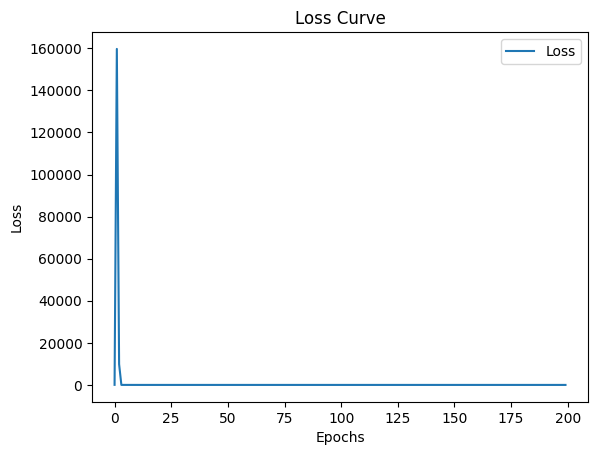

In [36]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

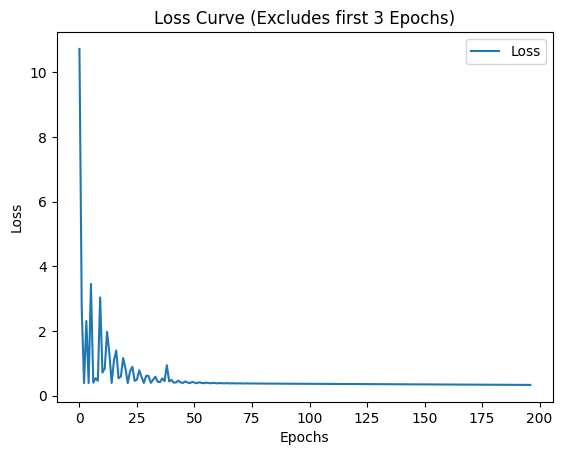

In [41]:
plt.plot(losses[3:], label="Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Curve (Excludes first 3 Epochs)")
plt.legend()
plt.show()


After looking at our results, we notice some really interesting trends. Firstly, our neural network actually performed significantly worse than both linear and polynomial fitting, which was unexpected. Our linear and polynomial fitting did amazingly. The mean squared error our linear model was 0.0000 on the training dataset and 0.0001 on the testing dataset, which is a great performance. Similarly, our polynomial model did well, with a mean squared error of 0.0000 on the training dataset and a mean squared error of 0.0007 on the testing dataset. Frankly, I didn't expect it to go this well, so I'm wondering if the dataset was manipulated to be this good for such types of regression, but I don't see anything suggesting that it was manipulated. Our neural network and K-nearest neighbors regressor did alright, but in comparison to the linear and polynomial regression models, it did far worse.

Our R2 coefficients are high in both our linear and polynomial model, and fairly high, although lower, in our K-nearest neighbors model.

Taking a closer look at our neural network, we see that the loss is greatest by a large margin in the first few epochs as expected. I've plotted the loss a second time so that we can see better how the loss decreases over epochs, since the loss of the first three epochs far overshadowed that of the later epochs, even immediately after. Looking the second graph, we see a fairly normal loss curve, which appears to stop decreasing by much around the 75 epoch range.

As a general conclusion, we've seen that linear and polynomial fitting work extremely well in prediction on this data set, while K-nearest neighbors and neural network performed comparatively worse. Based on the extreme accuracy of the results of linear and polynomial fitting, we have reason to suspect the data was manipulated, and of course, in practice, predicting sales based off data would require one to train models specific to their dataset (for example, Walmart sales will differ to say, Home Depot sales). However, we have provided a framework which can be easily modified to train models to predict sales on any sort of sales dataframes that are cleaned properly, and the methods used here will be useful in other similar projects.